In [1]:
import SimpleITK as sitk
import os

# dltk compatible with tensorflow 1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import pandas as pd
import time

from matplotlib import pyplot as plt
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Timer helper class for benchmarking reading methods
class Timer(object):
    """Timer class
       Wrap a will with a timing function
    """
    
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        self.t = time.time()
        
    def __exit__(self, *args, **kwargs):
        print("{} took {} seconds".format(
        self.name, time.time() - self.t))

In [3]:
# Set up parameters
batch_size = 5
iterations = 100

# Define the desired shapes and types of the training examples to pass to `read_fn`:
reader_params = {'n_examples': 1,
                 'example_size': [128, 224, 224],
                 'extract_examples': True}

reader_example_shapes = {'features': {'x': reader_params['example_size'] + [1,]},
                         'labels': {'y': []}}
 
reader_example_dtypes = {'features': {'x': tf.float32},
                         'labels': {'y': tf.int32}}

In [4]:
# Read some demo data from csv
all_filenames = pd.read_csv(
    '../DLTK/demographic_HH.csv',
    dtype=object,
    keep_default_na=False,
    na_values=[]).to_numpy()

# For demo purposes, we will only use the first 10 datasets from IXI HH
all_filenames = all_filenames[:10]

### Method 2: Using a TFRecord database

Load data for a single subject

In [5]:
def load_img(meta_data, params):
    x = []
    
    # Here, we parse the `subject_id` to construct a file path to read
    # an image from.
    subject_id = meta_data[0]
    data_path = '../DLTK/1mm'
    t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))

    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    sitk_t1 = sitk.ReadImage(t1_fn)
    t1 = sitk.GetArrayFromImage(sitk_t1)

    # Normalise the image to zero mean/unit std dev:
    t1 = whitening(t1)
    
    # Create a 4D Tensor with a dummy dimension for channels
    t1 = t1[..., np.newaxis]

    # Labels: Here, we parse the class *sex* from the file_references 
    # \in [1,2] and shift them to \in [0,1] for training:
    sex = np.int32(meta_data[1]) - 1
    y = sex
    
    # If training should be done on image patches for improved mixing, 
    # memory limitations or class balancing, call a patch extractor
    if params['extract_examples']:
        images = extract_random_example_array(
            t1,
            example_size=params['example_size'],
            n_examples=params['n_examples'])

        # Loop the extracted image patches and yield
        for e in range(params['n_examples']):
            x.append(images[e].astype(np.float32))

    # If desired (i.e. for evaluation, etc.), return the full images
    else:
        x = images
            
    return np.array(x), y  

Convert data to features

In [6]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    # Since this will be used to convert an np.array we don't use []
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

Write data into a TFRecords file

In [7]:
# path to save the TFRecords file
train_filename = 'train.tfrecords'  

# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for meta_data in all_filenames:
    
    # Load the image
    img, label = load_img(meta_data, reader_params)
    
    # Create a feature
    feature = {'train/label': _int64_feature(label),
               'train/image': _float_feature(img.ravel())}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()

/Users/alechay/opt/anaconda3/envs/DLweek3-4/lib/python3.7/site-packages/dltk/io/augmentation.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ex_image = image_list[j][slicer][np.newaxis]


Load TFRecord and decode data

In [8]:
def decode(serialized_example):
    # Decode examples stored in TFRecord
    # NOTE: make sure to specify the correct dimensions for the images
    features = tf.parse_single_example(
        serialized_example,
        features={'train/image': tf.FixedLenFeature([128, 224, 224, 1], tf.float32),
                  'train/label': tf.FixedLenFeature([], tf.int64)})

    # NOTE: No need to cast these features, as they are already `tf.float32` values.
    return features['train/image'], features['train/label']

dataset = tf.data.TFRecordDataset(train_filename).map(decode)
dataset = dataset.repeat(None)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

iterator = dataset.make_initializable_iterator()
features, labels = iterator.get_next()
nx = iterator.get_next()

with tf.train.MonitoredTrainingSession() as sess_rec:
    sess_rec.run(iterator.initializer)

    with Timer('TFRecord'):
        # Time TFRecord io
        for i in range(iterations):
            try:
                # Get next features-labels pair
                rec_batch_feat, rec_batch_lbl = sess_rec.run([features, labels])
                
            except tf.errors.OutOfRangeError:
                # Raised when we reach the end of the file.
                pass

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
TFRecord took 15.2190420627594 seconds


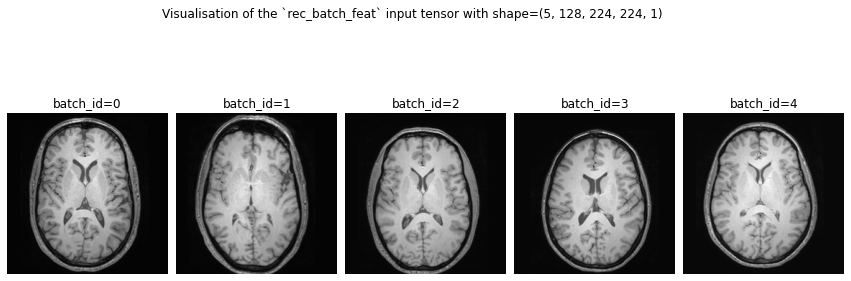

In [9]:
# Visualise the `rec_batch_feat` using matplotlib.
input_tensor_shape = rec_batch_feat.shape
center_slices = [s//2 for s in input_tensor_shape]

# Visualise the `gen_batch_feat` using matplotlib.
f, axarr = plt.subplots(1, input_tensor_shape[0], figsize=(15,5));
f.suptitle('Visualisation of the `rec_batch_feat` input tensor with shape={}'.format(input_tensor_shape))

for batch_id in range(input_tensor_shape[0]):
    # Extract a center slice image
    img_slice_ = np.squeeze(rec_batch_feat[batch_id, center_slices[1], :, :, :])
    img_slice_ = np.flip(img_slice_, axis=0)
    
    # Plot
    axarr[batch_id].imshow(img_slice_, cmap='gray');
    axarr[batch_id].axis('off')
    axarr[batch_id].set_title('batch_id={}'.format(batch_id))
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show(); 